# Re-scoring with Sagepy

The following notebook contains a basic re-scoring example with `sagepy`. You will:

* Read a collection of PSMs from a binary file containing sagepy created PSMs
* Calculate FDR with the Sage raw-scores
* Have a look at peptide predicted features that can help to improve the number of returned PSMs at a fixed FDR
* Use a re-scoring engine, here an [LDA-model](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html) from [scikit-learn](https://scikit-learn.org/stable/) to calculate the new score
* Compare number of identifications with and without re-scoring

This is the follow-up notebook of the "property_prediction" notebook. If you haven't read through it, we recommend you start there.

## Read the data

In [18]:
import os
import pandas as pd
from sagepy.utility import psm_collection_to_pandas, decompress_psms
from sagepy.qfdr.tdc import target_decoy_competition_pandas

# read the binary matches from disk
f = open(os.path.join("/media/hd01/CCSPred/HELA-GRAD110/imspy/total_psms.bin"), 'rb')
data = f.read()
f.close()

# convert binary file to PSM objects
PSM = decompress_psms(data)

# translate the collection of PSMs to pandas table
PSM_pandas = psm_collection_to_pandas(PSM)

## Plot the raw scores

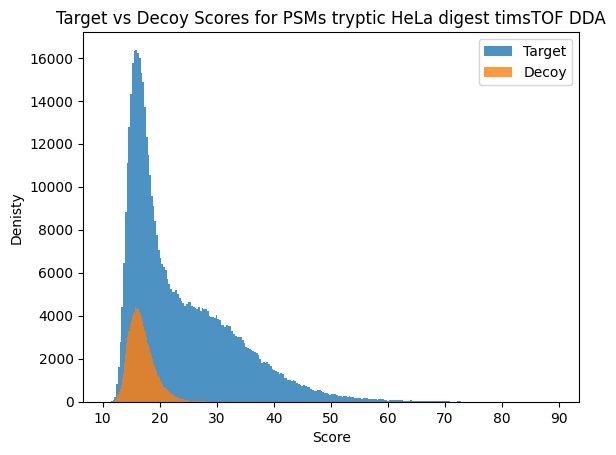

In [19]:
from matplotlib import pyplot as plt

TARGET = PSM_pandas[PSM_pandas.decoy == False]
DECOY = PSM_pandas[PSM_pandas.decoy]

plt.title("Target vs Decoy Scores for PSMs tryptic HeLa digest timsTOF DDA")
plt.hist(TARGET.hyperscore, density=False, alpha=.8, bins="auto", label="Target")
plt.hist(DECOY.hyperscore, density=False, alpha=.8, bins="auto", label="Decoy")
plt.xlabel("Score")
plt.ylabel("Denisty")
plt.legend()
plt.show()

## Generate a collection of initial "good" targets using the target-decoy competition with the old score

In [21]:
from sagepy.qfdr.tdc import target_decoy_competition_pandas

# target decoy competition, translating raw-scores to q-values
TDC_pandas = target_decoy_competition_pandas(
    PSM_pandas,
    score="hyperscore",
    method="peptide_psm_peptide",
)

TDC_pandas = pd.merge(TDC_pandas.drop(columns=["hyperscore"]), 
                      PSM_pandas, on=["spec_idx", "match_idx", "decoy"])

In [22]:
# we can select target hits with a q-value of 0.01, translating to 1 percent FDR
FDR_1_percent = TDC_pandas[(TDC_pandas.q_value <= 0.01) & (TDC_pandas.decoy == False)]

## Have a look at distributions of good targets and all decoys with respect to predicted features

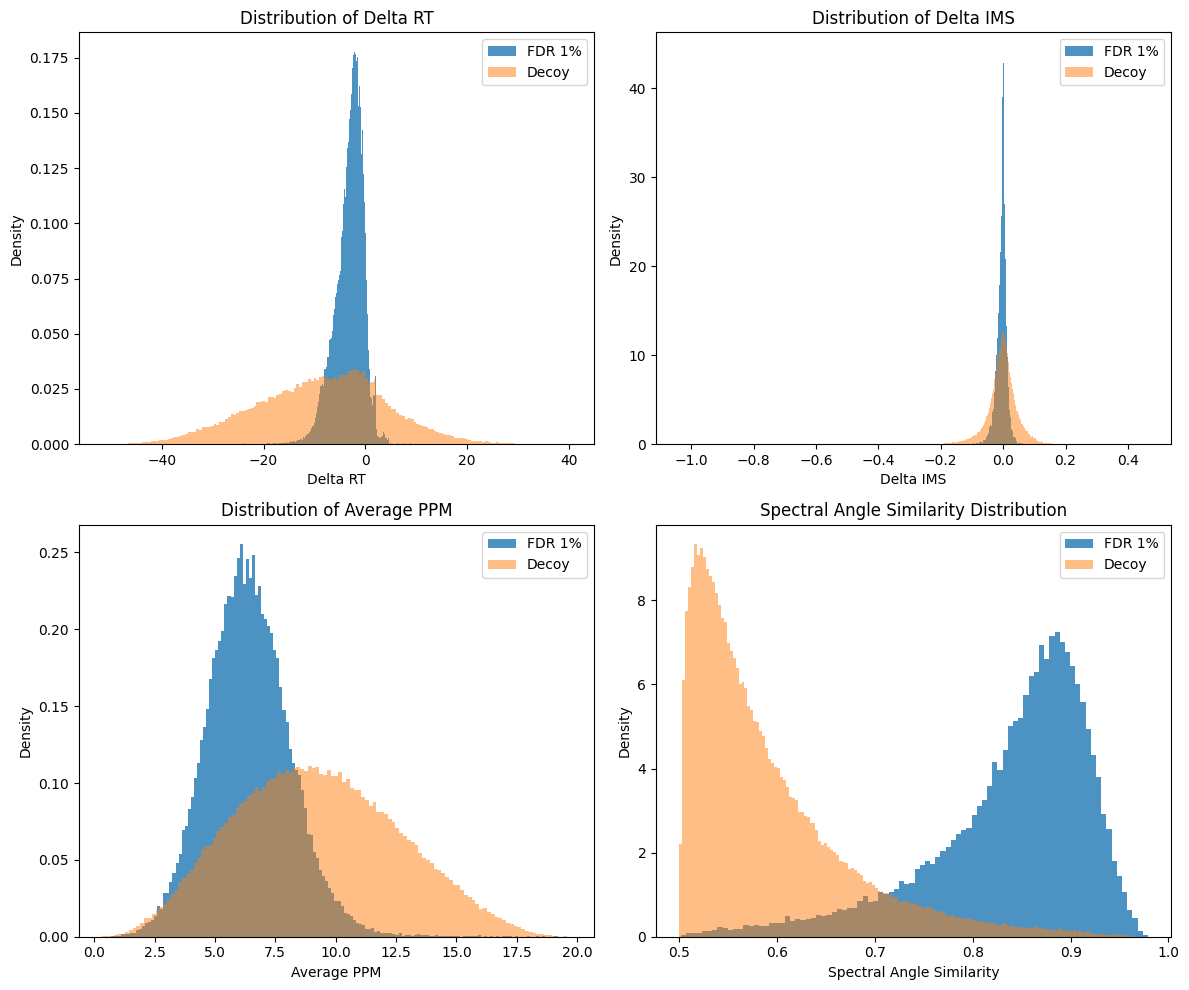

In [33]:
# 2x2 figure layout for delta-rt, delta-ims, median-ppm, and spectral-angle features target good vs decoy all
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Panel 1: delta_rt
axs[0, 0].hist(FDR_1_percent['delta_rt'], bins="auto", alpha=.8, density=True, label="FDR 1%")
axs[0, 0].hist(DECOY['delta_rt'], bins="auto", alpha=.5, density=True, label="Decoy")
axs[0, 0].set_title("Distribution of Delta RT")
axs[0, 0].set_xlabel("Delta RT")
axs[0, 0].set_ylabel("Density")
axs[0, 0].legend()

# Panel 2: delta_ims
axs[0, 1].hist(FDR_1_percent['delta_ims'], bins="auto", alpha=.8, density=True, label="FDR 1%")
axs[0, 1].hist(DECOY['delta_ims'], bins="auto", alpha=.5, density=True, label="Decoy")
axs[0, 1].set_title("Distribution of Delta IMS")
axs[0, 1].set_xlabel("Delta IMS")
axs[0, 1].set_ylabel("Density")
axs[0, 1].legend()

# Panel 3: median_ppm
axs[1, 0].hist(FDR_1_percent['average_ppm'], bins="auto", alpha=.8, density=True, label="FDR 1%")
axs[1, 0].hist(DECOY['average_ppm'], bins="auto", alpha=.5, density=True, label="Decoy")
axs[1, 0].set_title("Distribution of Average PPM")
axs[1, 0].set_xlabel("Average PPM")
axs[1, 0].set_ylabel("Density")
axs[1, 0].legend()

# Panel 4: cosine_similarity converted to spectral angle sim
axs[1, 1].hist(FDR_1_percent.spectral_angle_similarity, bins="auto", alpha=.8, density=True, label="FDR 1%")
axs[1, 1].hist(DECOY.spectral_angle_similarity, bins="auto", alpha=.5, density=True, label="Decoy")
axs[1, 1].set_title("Spectral Angle Similarity Distribution")
axs[1, 1].set_xlabel("Spectral Angle Similarity")
axs[1, 1].set_ylabel("Density")
axs[1, 1].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

## Use LDA as re-scoring engine to transform the available additional peptide features into a better score

In [34]:
from sagepy.rescore.lda import rescore_lda

# this will run a k-fold cross validation with 5 split (train 4/5, predict 1/5 of the data)
PSM_rescored = rescore_lda(
    psm_collection=PSM,
    num_splits=5,
)

Re-scoring PSMs: 100%|████████████████████████████████████████████████| 5/5 [01:55<00:00, 23.03s/it]


In [42]:
# target-decoy competition is performed again, now using re-score instead of hyper-score
TDC_pandas_rescored = target_decoy_competition_pandas(
    psm_collection_to_pandas(
        PSM_rescored,
    ),
    method="peptide_psm_peptide",
    score="re_score",
)

TDC_pandas_rescored = pd.merge(TDC_pandas_rescored.drop(columns=["re_score"]), 
                               PSM_pandas, on=["spec_idx", "match_idx", "decoy"])

# we can select target hits with a q-value of 0.01, translating to 1 percent FDR
FDR_1_percent_rescored = TDC_pandas_rescored[(TDC_pandas_rescored.q_value <= 0.01) & (TDC_pandas_rescored.decoy == False)]

## Inspect distribution of learned re-score

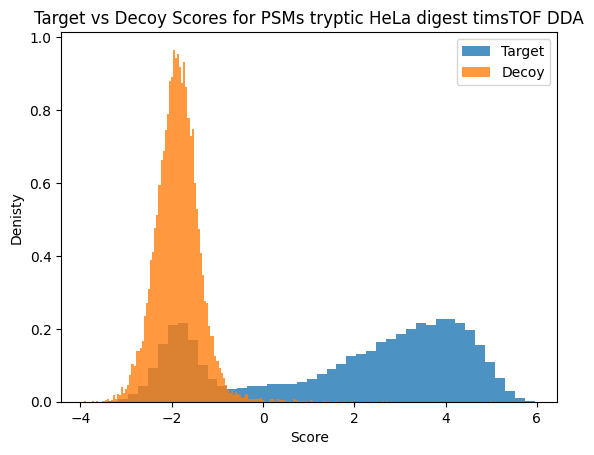

In [43]:
from matplotlib import pyplot as plt

TARGET = TDC_pandas_rescored[TDC_pandas_rescored.decoy == False]
DECOY = TDC_pandas_rescored[TDC_pandas_rescored.decoy]

plt.title("Target vs Decoy Scores for PSMs tryptic HeLa digest timsTOF DDA")
plt.hist(TARGET.re_score, density=True, alpha=.8, bins="auto", label="Target")
plt.hist(DECOY.re_score, density=True, alpha=.8, bins="auto", label="Decoy")
plt.xlabel("Score")
plt.ylabel("Denisty")
plt.legend()
plt.show()

## Check if re-scoring improved number of identified peptides below a certain FDR

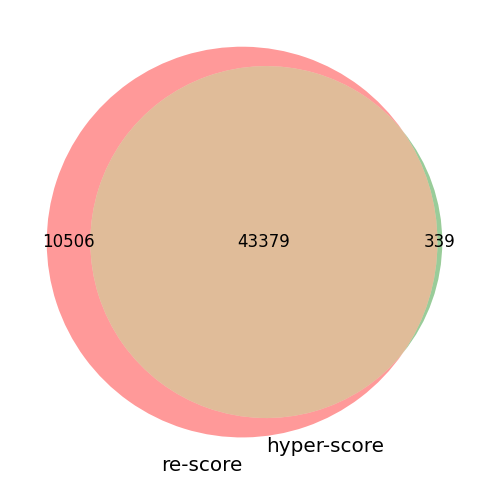

In [44]:
from matplotlib_venn import venn2

plt.figure(figsize=(5,5), dpi=120)
venn2([set(FDR_1_percent_rescored.sequence), set(FDR_1_percent.sequence)], ("re-score", "hyper-score"))
plt.show()